# Mini projekt 6 - NLP

Jan Jędrzejewski, Dominik Łopatecki

## Klasyfikacja hoteli pod względem liczby gwiazdek na podstawie recenzji

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
from torch import nn

In [ ]:
!pip install load_dataset
!pip install evaluate
!pip install transformers

In [ ]:
import transformers
from transformers import *
from datasets import load_dataset, Dataset
import evaluate
from tqdm import tqdm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def test_net_confusion_matrix(net, data_loader):
    net.eval()
    target, predictions = [], []
    for batch in data_loader:
        labels = batch["rating"].to(device)
        batch = {"attention_mask": batch['attention_mask'].to(device), "input_ids": batch['input_ids'].to(device)}#, "token_type_ids":batch['token_type_ids'].to(device)}

        with torch.no_grad():
            outputs = net(**batch)

        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1)
        target += labels
        predictions += preds

    target, predictions = torch.tensor(target).cpu(), torch.tensor(predictions).cpu()
    return confusion_matrix(target, predictions)

def get_accuracy(net, data_loader):
    metric = evaluate.load("accuracy")                                              ### to sa po prostu metryki
    net.eval()
    for batch in data_loader:
        labels = batch["rating"].to(device)
        batch = {"attention_mask": batch['attention_mask'].to(device), "input_ids": batch['input_ids'].to(device)}#, "token_type_ids":batch['token_type_ids'].to(device)}

        with torch.no_grad():
            outputs = net(**batch)

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        metric.add_batch(predictions=predictions, references=labels)

    return metric.compute()['accuracy']

# Dane treningowe i testowe

In [ ]:
!unzip p6.zip

unzip:  cannot find or open p6.zip, p6.zip.zip or p6.zip.ZIP.


In [64]:
trainset = pd.read_csv("train_data.csv")
trainset

,review,rating
0,location not palace excellent hotel booke dthe...,4
1,respite definitely not place stay looking ultr...,3
2,stunning truly memorable spot right beach nusa...,4
3,solid business hotel near embassy stayed hotel...,3
4,nice place make sure lock money warning money ...,3
...,...,...
16387,great base explore new york stayed 4 nights en...,4
16388,wonderful advert paris wonderful introduction ...,4
16389,ideal relaxing holdiay rachel jay green liverp...,3
16390,"watch food, husband went resort 4 nights chris...",2


In [63]:
testset = pd.read_csv("test_data.csv", header=None)
testset.columns = ['review']
testset

,review
0,great hotel location stayed 4 nts 24th 28th ja...
1,"n't return overall disappointed hotel, no hot ..."
2,great value location desired problem hotel loc...
3,kind helpfull people people kind helpful.we no...
4,absolutely fabulous melia comfortable star hot...
...,...
4094,cockroaches dirty carpeting not consider 10 de...
4095,"ca n't wait return, husband stayed el san juan..."
4096,coming home stay wind chimes inn like coming h...
4097,good hotel great location stayed apsis splendi...


array([[<Axes: title={'center': 'rating'}>]], dtype=object)

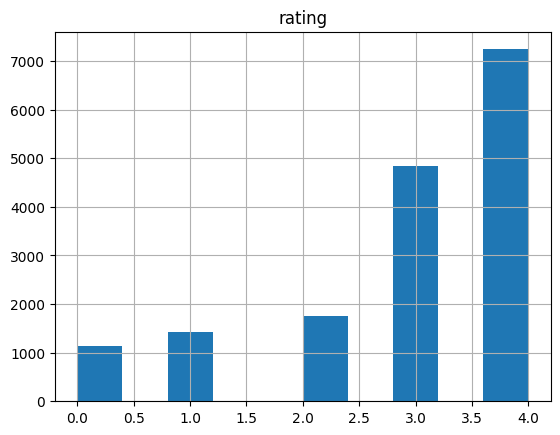

In [7]:
trainset.hist(column="rating")

In [ ]:
targets = list(trainset["rating"])
print(f"class 0 (1 star): {targets.count(0)/len(targets)}")
print(f"class 1 (2 star): {targets.count(1)/len(targets)}")
print(f"class 2 (3 star): {targets.count(2)/len(targets)}")
print(f"class 3 (4 star): {targets.count(3)/len(targets)}")
print(f"class 4 (5 star): {targets.count(4)/len(targets)}")

class 0 (1 star): 0.06936310395314788
class 1 (2 star): 0.08748169838945827
class 2 (3 star): 0.10657637872132748
class 3 (4 star): 0.29471693509028796
class 4 (5 star): 0.4418618838457784


# Model 0 - sieć sekwencyjna LSTM

In [65]:
raw_train_dataset = Dataset.from_pandas(trainset)
combined_dataset = raw_train_dataset.train_test_split(test_size=0.2)
combined_dataset['train']

Dataset({
    features: ['review', 'rating'],
    num_rows: 13113
})

In [66]:
combined_dataset['validate'] = combined_dataset['test']
combined_dataset['validate']

Dataset({
    features: ['review', 'rating'],
    num_rows: 3279
})

In [67]:
combined_dataset['test'] = Dataset.from_pandas(testset)
combined_dataset['test']

Dataset({
    features: ['review'],
    num_rows: 4099
})

In [68]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import re

import gensim.downloader as api
from gensim.models.word2vec import Word2Vec
corpus = api.load('text8')
gensim_model = Word2Vec(corpus)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


[===============================================---] 95.8% 30.3/31.6MB downloaded

In [69]:
emb_weights = torch.FloatTensor(gensim_model.wv.vectors)
print(emb_weights.size())
embedding = nn.Embedding.from_pretrained(emb_weights)
embedding.requires_grad = False

tokenizer = gensim_model.wv.key_to_index

def tokenize_reviews(dataset):
    clean_reviews_tokenized = []
    for review in dataset['review']:
        unknows = 0
        all_parsed = 0
        review_tokenized = []
        for word in review.split():
            all_parsed+=1
            try:
                review_tokenized.append(tokenizer[word.lower()])
            except:
                unknows +=1
        clean_reviews_tokenized.append(review_tokenized)
    return clean_reviews_tokenized

torch.Size([71290, 100])


In [70]:
from torch.utils.data import Dataset, DataLoader

class ReviewDataset(Dataset):
    def __init__(self, data,labels):
        self.data = []
        for d, l in zip(data,labels):
            self.data.append((torch.from_numpy(np.array(d)).long(),torch.tensor(l).long()))


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        in_data, target = self.data[idx]
        return in_data, target

In [71]:
train_data = ReviewDataset(np.array(tokenize_reviews(combined_dataset['train']), dtype=object), np.array(combined_dataset['train']['rating'], dtype=np.int64))
validate_data = ReviewDataset(np.array(tokenize_reviews(combined_dataset['validate']), dtype=object), np.array(combined_dataset['validate']['rating'], dtype=np.int64))
test_data = ReviewDataset(np.array(tokenize_reviews(combined_dataset['test']), dtype=object), np.zeros(4099))

In [72]:
from torch.nn.utils.rnn import pad_sequence
def pad_collate(batch):
    (xx, yy) = zip(*batch)
    x_lens = [len(x)-1 for x in xx]

    xx_pad = pad_sequence(xx, batch_first=True, padding_value=0)
    yy = torch.stack(yy)
    return xx_pad, yy, x_lens

In [73]:
train_loader = DataLoader(train_data, batch_size=32, collate_fn=pad_collate, shuffle=True)
validate_loader = DataLoader(validate_data, batch_size=32, collate_fn=pad_collate, shuffle=False)
test_loader = DataLoader(test_data, batch_size=1, collate_fn=pad_collate, shuffle=False)

### Regresor LSTM

In [74]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
class LSTMRegressor(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, out_size, emb_weights, bidirectional = False):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        if bidirectional:
            self.bidirectional = 2
        else:
            self.bidirectional = 1
        self.embeddings = nn.Embedding.from_pretrained(emb_weights)
        self.embeddings.requires_grad = False   # ustawiamy aby embedingi się nie trenowały
        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, bidirectional=bidirectional, batch_first=False)
        self.fc = nn.Linear(hidden_size*self.bidirectional, out_size)

    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.num_layers*self.bidirectional , batch_size, self.hidden_size)
        state = torch.zeros(self.num_layers*self.bidirectional , batch_size, self.hidden_size)
        return hidden, state

    def forward(self, x, len_x, hidden):
        x = self.embeddings(x)
        x = torch.transpose(x,0,1)
        all_outputs, hidden = self.lstm(x, hidden)
        all_outputs = torch.transpose(all_outputs,0,1)
        last_seq_items = all_outputs[range(all_outputs.shape[0]), len_x]
        out = last_seq_items#all_outputs[-1]#torch.flatten(all_outputs,1)
        x = self.fc(out)
        return x, hidden


In [108]:
lstm_model = LSTMRegressor(100, 500, 3, 5, emb_weights).to(device)
lstm_model

LSTMRegressor(
  (embeddings): Embedding(71290, 100)
  (lstm): LSTM(100, 500, num_layers=3)
  (fc): Linear(in_features=500, out_features=5, bias=True)
)

### Trening

In [109]:
optimizer = torch.optim.Adam(lstm_model.parameters(), lr = 0.001)
loss_fun = nn.CrossEntropyLoss()
lstm_model.train()

for epoch in tqdm(range(31)):
    losses = 0
    batches = 0
    for x, targets, len_x in train_loader:
        x, targets = x.to(device), targets.to(device)
        hidden, state = lstm_model.init_hidden(x.size(0))
        hidden, state = hidden.to(device), state.to(device)
        preds, _ = lstm_model(x, len_x, (hidden,state))
        preds = torch.argmax(preds, dim=-1)
        preds, targets = torch.tensor(preds, dtype=torch.float, requires_grad = True), torch.tensor(targets, dtype=torch.float, requires_grad = True)
        loss = loss_fun(preds, targets)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses += loss.item()
        batches +=1
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, loss: {losses/batches:.3}")


  0%|          | 0/31 [00:00<?, ?it/s]<ipython-input-109-569e3a76c2ec>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds, targets = torch.tensor(preds, dtype=torch.float, requires_grad = True), torch.tensor(targets, dtype=torch.float, requires_grad = True)
  3%|▎         | 1/31 [00:22<11:08, 22.28s/it]

Epoch: 0, loss: 3.27e+02


 35%|███▌      | 11/31 [04:05<07:23, 22.18s/it]

Epoch: 10, loss: 3.27e+02


 68%|██████▊   | 21/31 [07:49<03:43, 22.30s/it]

Epoch: 20, loss: 3.27e+02


100%|██████████| 31/31 [11:31<00:00, 22.31s/it]

Epoch: 30, loss: 3.27e+02


In [110]:
lstm_model.eval()
correct, all = 0, 0
for x, targets, len_x in train_loader:
        x, targets = x.to(device), targets.to(device)
        hidden, state = lstm_model.init_hidden(x.size(0))
        hidden, state = hidden.to(device), state.to(device)
        preds, _ = lstm_model(x, len_x, (hidden,state))
        preds = torch.argmax(preds, dim=-1)
        for i in range(len(preds)):
          if preds[i] == targets[i]:
            correct +=1
        all += len(preds)
print(f"Train set accuracy: {correct/all}")

correct, all = 0, 0
for x, targets, len_x in validate_loader:
        x, targets = x.to(device), targets.to(device)
        hidden, state = lstm_model.init_hidden(x.size(0))
        hidden, state = hidden.to(device), state.to(device)
        preds, _ = lstm_model(x, len_x, (hidden,state))
        preds = torch.argmax(preds, dim=-1)
        for i in range(len(preds)):
          if preds[i] == targets[i]:
            correct +=1
        all += len(preds)
print(f"Validate set accuracy: {correct/all}")


Train set accuracy: 0.10691680012201632
Validate set accuracy: 0.10521500457456541


Model oparty na komórce LSTM daje losowe wartości. W ogóle się nie uczy - nie maleje loss podczas treningu. Ten model wymagałby bardzo dużej liczby warstw i wag oraz długiego uczenia aby dawał dobre rezultaty.

# Model 1 - pretrained model

## Tokenizacja danych - Dataloadery: treningowy, walidacyjny i testowy

In [ ]:
model_name = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.30.2",
  "vocab_size": 30522
}



loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/tokenizer_config.json
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropo

loading weights file model.safetensors from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/model.safetensors
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification 

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples["review"], padding="max_length", truncation=True)

In [ ]:
raw_trainsets = load_dataset("csv", data_files="train_data.csv")["train"]
raw_testsets = Dataset.from_pandas(testset)
raw_trainsets

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-9a540ad339d2ee60/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Dataset({
    features: ['review', 'rating'],
    num_rows: 16392
})

In [ ]:
raw_testsets

Dataset({
    features: ['review'],
    num_rows: 4099
})

In [ ]:
tokenized_trainset = raw_trainsets.map(tokenize_function, batched=True)
tokenized_testset = raw_testsets.map(tokenize_function, batched=True)
tokenized_trainset

Map:   0%|          | 0/16392 [00:00<?, ? examples/s]

Map:   0%|          | 0/4099 [00:00<?, ? examples/s]

Dataset({
    features: ['review', 'rating', 'input_ids', 'attention_mask'],
    num_rows: 16392
})

In [ ]:
tokenized_testset

Dataset({
    features: ['review', 'input_ids', 'attention_mask'],
    num_rows: 4099
})

In [ ]:
tokenized_trainset = tokenized_trainset.remove_columns(["review"])
tokenized_trainset.set_format("torch")

train_valid_set = tokenized_trainset.train_test_split(test_size=0.2)
train_dataset = train_valid_set["train"]
validation_dataset = train_valid_set["test"]

train_dataset

Dataset({
    features: ['rating', 'input_ids', 'attention_mask'],
    num_rows: 13113
})

In [ ]:
tokenized_testset = tokenized_testset.remove_columns(["review"])
tokenized_testset.set_format("torch")                                                            ### ustawienie formatu stokenizowanych danych na format torcha
test_dataset = tokenized_testset
test_dataset

Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 4099
})

In [ ]:
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=32)
eval_dataloader = DataLoader(validation_dataset, batch_size=32)
test_dataloader = DataLoader(tokenized_testset, batch_size=1)

## distilbert-base-uncased

In [ ]:
model_name = 'distilbert-base-uncased'
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=5)
optimizer = optim.Adam(model.parameters(), lr=5e-5)
model.to(device)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.30.2",
  "vocab_size": 30522
}

loading weights file model.safetensors

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [ ]:
 model.load_state_dict(torch.load(model_name+'-dict', map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
num_epochs = 5
loss_fun = nn.CrossEntropyLoss()

for epoch in range(num_epochs):
    losses = []
    for batch in tqdm(train_dataloader):

        labels = batch["rating"].to(device)
        batch = {"attention_mask": batch['attention_mask'].to(device), "input_ids": batch['input_ids'].to(device)}#, "token_type_ids":batch['token_type_ids'].to(device)}
        outputs = model(**batch)
        loss = loss_fun(outputs.logits, labels)
        loss.backward()

        optimizer.step()
#         lr_scheduler.step()
        optimizer.zero_grad()
#         progress_bar.update(1)
        losses.append(loss.item())
    print(np.mean(losses))

# torch.save(model.state_dict(), model_name+'-dict')

100%|██████████| 410/410 [09:56<00:00,  1.46s/it]


0.080622219985987


100%|██████████| 410/410 [10:08<00:00,  1.48s/it]


0.06741227625880572


100%|██████████| 410/410 [10:08<00:00,  1.48s/it]


0.05106473167358739


100%|██████████| 410/410 [10:07<00:00,  1.48s/it]


0.0549775900015403


100%|██████████| 410/410 [10:08<00:00,  1.48s/it]

0.06309825387079178


In [ ]:
torch.save(model.state_dict(), model_name+'-dict')

### Wyniki po 5 epokach

Text(0.5, 1.0, 'Validate dataset')

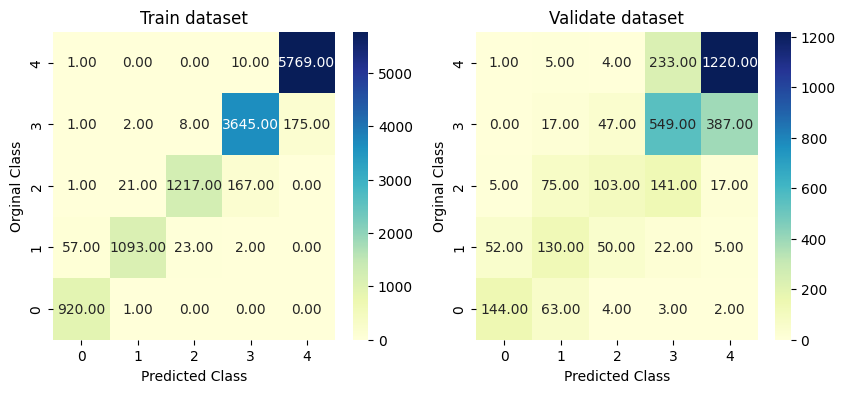

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.heatmap(
    np.flip(test_net_confusion_matrix(model, train_dataloader), 0),
    annot=True,
    cmap="YlGnBu",
    fmt=".2f",
    xticklabels=[0, 1, 2, 3, 4],
    yticklabels=[4, 3, 2, 1, 0],
)
plt.xlabel("Predicted Class")
plt.ylabel("Orginal Class")
plt.title("Train dataset")

plt.subplot(1,2,2)
sns.heatmap(
    np.flip(test_net_confusion_matrix(model, eval_dataloader), 0),
    annot=True,
    cmap="YlGnBu",
    fmt=".2f",
    xticklabels=[0, 1, 2, 3, 4],
    yticklabels=[4, 3, 2, 1, 0],
)
plt.xlabel("Predicted Class")
plt.ylabel("Orginal Class")
plt.title("Validate dataset")
plt.show()

### Wyniki po 10 epokach

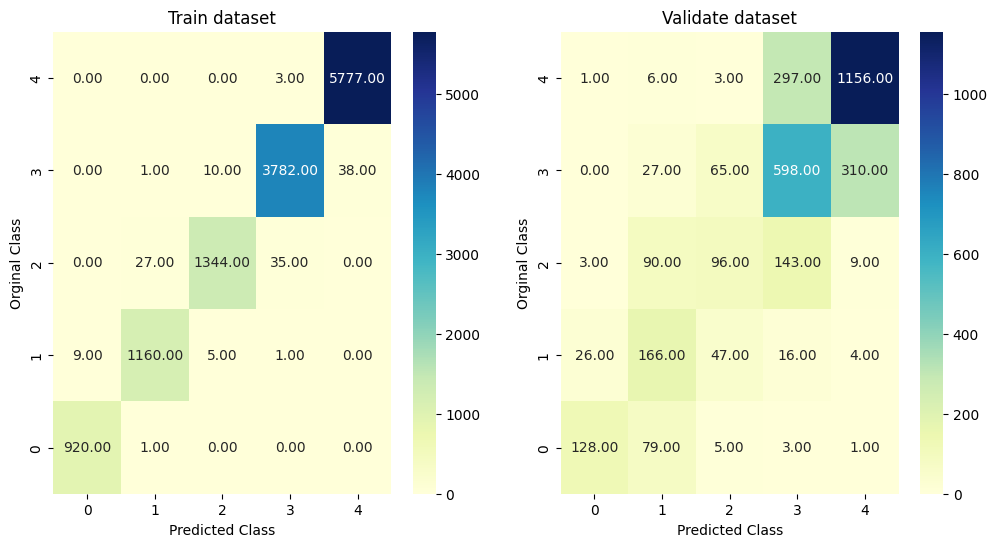

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.heatmap(
    np.flip(test_net_confusion_matrix(model, train_dataloader), 0),
    annot=True,
    cmap="YlGnBu",
    fmt=".2f",
    xticklabels=[0, 1, 2, 3, 4],
    yticklabels=[4, 3, 2, 1, 0],
)
plt.xlabel("Predicted Class")
plt.ylabel("Orginal Class")
plt.title("Train dataset")

plt.subplot(1,2,2)
sns.heatmap(
    np.flip(test_net_confusion_matrix(model, eval_dataloader), 0),
    annot=True,
    cmap="YlGnBu",
    fmt=".2f",
    xticklabels=[0, 1, 2, 3, 4],
    yticklabels=[4, 3, 2, 1, 0],
)
plt.xlabel("Predicted Class")
plt.ylabel("Orginal Class")
plt.title("Validate dataset")
plt.show()

Model osiągnął bardzo wysoką skuteczność na zbiorze treningowym. Dłuższe uczenie niż kilka epok nie przynosi większych korzyści. Na macierzach pomyłek dobrze odzwierciedlone jest niezbalansowanie klas. Model nauczył się przewidywać najliczniejszą klasę. W kolejnych dwóch modelach spróbujemy zwalczyć nierówny rozkład przykładów.

# Model 2 - ważenie klas

Praktycznie identyczny do modelu pierwszego. Dodajemy wagi do funkcji straty - proporcjonalne do występowania klas w zbiorze treningowym. Liczbę epok ograniczamy do czterech.

In [ ]:
model_name = 'distilbert-base-uncased'
model2 = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=5)

optimizer = optim.Adam(model2.parameters(), lr=5e-5)
model2.to(device)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.30.2",
  "vocab_size": 30522
}

loading weights file model.safetensors

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [ ]:
num_epochs = 4
loss_fun = nn.CrossEntropyLoss(weight=torch.Tensor([14, 11, 10, 3.4, 2.2]).to(device))

for epoch in range(num_epochs):
    losses = []
    for batch in tqdm(train_dataloader):

        labels = batch["rating"].to(device)
        batch = {"attention_mask": batch['attention_mask'].to(device), "input_ids": batch['input_ids'].to(device)}#, "token_type_ids":batch['token_type_ids'].to(device)}
        outputs = model2(**batch)
        loss = loss_fun(outputs.logits, labels)
        loss.backward()

        optimizer.step()
#         lr_scheduler.step()
        optimizer.zero_grad()
#         progress_bar.update(1)
        losses.append(loss.item())
    print(np.mean(losses))

torch.save(model2.state_dict(), 'model2-dict')

100%|██████████| 410/410 [09:48<00:00,  1.44s/it]


1.0161197966191826


100%|██████████| 410/410 [09:46<00:00,  1.43s/it]


0.7389730788585617


100%|██████████| 410/410 [09:46<00:00,  1.43s/it]


0.5281511693466


100%|██████████| 410/410 [09:45<00:00,  1.43s/it]


0.3693914090533082


100%|██████████| 410/410 [09:46<00:00,  1.43s/it]


0.255265950148062


In [ ]:
print(f"Train set accuracy: {get_accuracy(model2, train_dataloader)}")
print(f"Validate set accuracy: {get_accuracy(model2, eval_dataloader)}")

Train set accuracy: 0.9234347593990696
Validate set accuracy: 0.6678865507776761


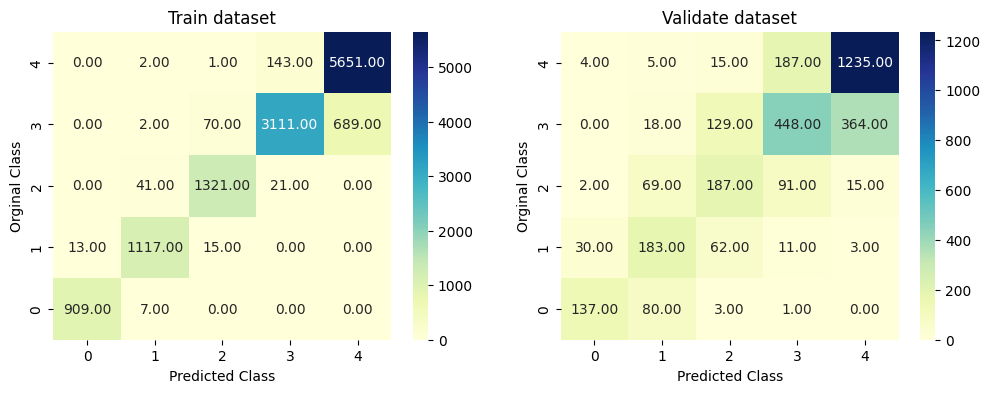

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.heatmap(
    np.flip(test_net_confusion_matrix(model2, train_dataloader), 0),annot=True,cmap="YlGnBu",fmt=".2f",xticklabels=[0, 1, 2, 3, 4],yticklabels=[4, 3, 2, 1, 0],
)
plt.xlabel("Predicted Class")
plt.ylabel("Orginal Class")
plt.title("Train dataset")

plt.subplot(1,2,2)
sns.heatmap(
    np.flip(test_net_confusion_matrix(model2, eval_dataloader), 0),annot=True,cmap="YlGnBu",fmt=".2f",xticklabels=[0, 1, 2, 3, 4],yticklabels=[4, 3, 2, 1, 0],
)
plt.xlabel("Predicted Class")
plt.ylabel("Orginal Class")
plt.title("Validate dataset")
plt.show()

Na macierzach pomyłek widać sporą różnicę. Lepiej wychodzi rozpoznawanie klas najmniej licznych 0-2, kosztem skuteczności w rozpoznawaniu klasy najpopularniejszej. Skuteczność modelu na zbiorze walidacyjnym jest natomiast identyczna w okolicy 66%.

# Model 3 - upsampling

Zamiast przypisywać wagi dodajmy przykłady klas mniej licznych aby były równomiernie reprezentowane. Nowe przykłady dla danej klasy generyjemy łącząc początek jednej recenzji tej klasy z końcem innej recenzji tej klasy.

In [49]:
dvided_by_rating = []
for _ in range(5): dvided_by_rating.append([])

for review, rating in zip(trainset['review'], trainset['rating']):
    dvided_by_rating[rating].append(review)

In [50]:
def gen_review(cla):
    first_part, second_part = np.random.choice(dvided_by_rating[cla], size=2)
    first_part = first_part.split()
    second_part = second_part.split()
    new_review = first_part[:int(len(first_part)/2)] + second_part[int(len(second_part)/2):]
    return " ".join(new_review)

In [51]:
new_examples = []
for i in range(4):
    examples_to_generate = len(dvided_by_rating[4]) - len(dvided_by_rating[i])
    for _ in range(examples_to_generate):
        row = {'review': gen_review(i), 'rating': i}
        new_examples.append(row)

array([[<Axes: title={'center': 'rating'}>]], dtype=object)

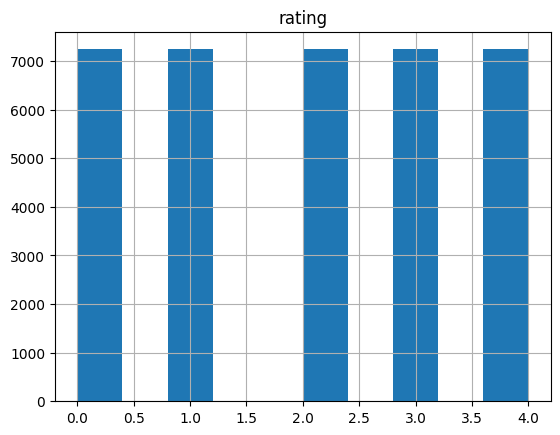

In [52]:
trainset = pd.concat([trainset, pd.DataFrame.from_records(new_examples)], ignore_index=True)
trainset.hist(column="rating")

Otrzymaliśmy zbalansowany zbiór danych

In [53]:
raw_trainsets = Dataset.from_pandas(trainset)
raw_testsets = Dataset.from_pandas(testset)
raw_trainsets

Dataset({
    features: ['review', 'rating'],
    num_rows: 36215
})

In [57]:
raw_trainsets_org = load_dataset("csv", data_files="train_data.csv")["train"]
tokenized_trainset_org = raw_trainsets_org.map(tokenize_function, batched=True)
tokenized_trainset_org = tokenized_trainset_org.remove_columns(["review"])
tokenized_trainset_org.set_format("torch")
train_valid_set_org = tokenized_trainset_org.train_test_split(test_size=0.2)
validation_dataset_org = train_valid_set_org["test"]
eval_dataloader = DataLoader(validation_dataset_org, batch_size=32)

  0%|          | 0/1 [00:00<?, ?it/s]

In [54]:
model_name = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    return tokenizer(examples["review"], padding="max_length", truncation=True)

tokenized_trainset = raw_trainsets.map(tokenize_function, batched=True)
tokenized_testset = raw_testsets.map(tokenize_function, batched=True)

tokenized_trainset = tokenized_trainset.remove_columns(["review"])
tokenized_trainset.set_format("torch")

train_valid_set = tokenized_trainset.train_test_split(test_size=0.2)
train_dataset = train_valid_set["train"]
validation_dataset = train_valid_set["test"]

tokenized_testset = tokenized_testset.remove_columns(["review"])
tokenized_testset.set_format("torch")                                                            ### ustawienie formatu stokenizowanych danych na format torcha
test_dataset = tokenized_testset
test_dataset

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=32)
eval_dataloader = DataLoader(validation_dataset, batch_size=32)
test_dataloader = DataLoader(tokenized_testset, batch_size=1)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.30.2",
  "vocab_size": 30522
}

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapsh

Map:   0%|          | 0/36215 [00:00<?, ? examples/s]

Map:   0%|          | 0/4099 [00:00<?, ? examples/s]

In [27]:
model_name = 'distilbert-base-uncased'
model3 = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=5)

optimizer = optim.Adam(model3.parameters(), lr=5e-5)
model3.to(device)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.30.2",
  "vocab_size": 30522
}

loading weights file model.safetensors

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [28]:
num_epochs = 3
loss_fun = nn.CrossEntropyLoss()

for epoch in range(num_epochs):
    losses = []
    for batch in tqdm(train_dataloader):

        labels = batch["rating"].to(device)
        batch = {"attention_mask": batch['attention_mask'].to(device), "input_ids": batch['input_ids'].to(device)}#, "token_type_ids":batch['token_type_ids'].to(device)}
        outputs = model3(**batch)
        loss = loss_fun(outputs.logits, labels)
        loss.backward()

        optimizer.step()
#         lr_scheduler.step()
        optimizer.zero_grad()
#         progress_bar.update(1)
        losses.append(loss.item())

    print(f'Accuracy:{get_accuracy(model3, eval_dataloader)}')
    print(np.mean(losses))

torch.save(model3.state_dict(), 'model3-dict')

100%|██████████| 906/906 [20:11<00:00,  1.34s/it]


Accuracy:0.7984260665470109
0.7335871699498452


100%|██████████| 906/906 [20:11<00:00,  1.34s/it]


Accuracy:0.8333563440563303
0.33051023963287834


100%|██████████| 906/906 [20:11<00:00,  1.34s/it]


Accuracy:0.8539279304155737
0.17017518607467808


In [58]:
print(f"Train set accuracy: {get_accuracy(model3, train_dataloader)}")
print(f"Validate set accuracy: {get_accuracy(model3, eval_dataloader)}")

Train set accuracy: 0.923753969349717
Validate set accuracy: 0.9115584019518146


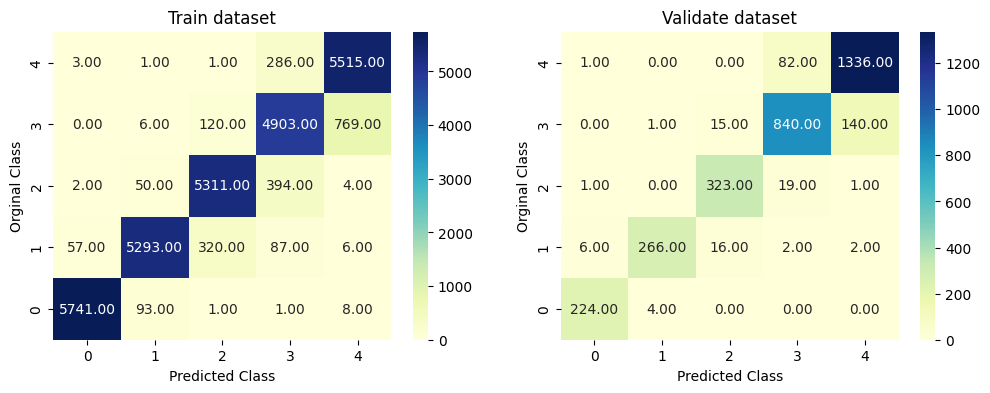

In [62]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.heatmap(
    np.flip(test_net_confusion_matrix(model3, train_dataloader), 0),annot=True,cmap="YlGnBu",fmt=".2f",xticklabels=[0, 1, 2, 3, 4],yticklabels=[4, 3, 2, 1, 0],
)
plt.xlabel("Predicted Class")
plt.ylabel("Orginal Class")
plt.title("Train dataset")

plt.subplot(1,2,2)
sns.heatmap(
    np.flip(test_net_confusion_matrix(model3, eval_dataloader), 0),annot=True,cmap="YlGnBu",fmt=".2f",xticklabels=[0, 1, 2, 3, 4],yticklabels=[4, 3, 2, 1, 0],
)
plt.xlabel("Predicted Class")
plt.ylabel("Orginal Class")
plt.title("Validate dataset")
plt.show()

W tym modelu na zbiorze treningowym mamy prawie bezbłędną skuteczność już po 3 epokach. Od razu widzimy że jest porównywalna ilość predykcji dla każdej z klas. Dla zbioru walidacyjnego zdecydowanie lepsza skuteczność na poziomie 91% w porównaniu do pozostałych metod.

# Model 4 - bert-base tokenizer

In [42]:
model_name = 'distilbert-base-uncased'
tokenizer_alternative_tokenizer = BertTokenizer.from_pretrained('dslim/bert-base-NER')


def tokenize_function_alternative(examples):
    return tokenizer_alternative_tokenizer(examples["review"], padding="max_length", truncation=True)

testset = pd.read_csv("test_data.csv", header=None)
testset.columns = ['review']

raw_trainsets = load_dataset("csv", data_files="train_data.csv")["train"]
raw_testsets = Dataset.from_pandas(testset)

tokenized_trainset_alternative_tokenizer = raw_trainsets.map(tokenize_function_alternative, batched=True)
tokenized_testset_alternative_tokenizer = raw_testsets.map(tokenize_function_alternative, batched=True)

tokenized_trainset_alternative_tokenizer = tokenized_trainset_alternative_tokenizer.remove_columns(["review"])
tokenized_trainset_alternative_tokenizer.set_format("torch")

train_valid_set_alternative_tokenizer = tokenized_trainset_alternative_tokenizer.train_test_split(test_size=0.2)
train_dataset_alternative_tokenizer = train_valid_set_alternative_tokenizer["train"]
validation_dataset_alternative_tokenizer = train_valid_set_alternative_tokenizer["test"]

tokenized_testset_alternative_tokenizer = tokenized_testset_alternative_tokenizer.remove_columns(["review"])
tokenized_testset_alternative_tokenizer.set_format("torch")                                                            ### ustawienie formatu stokenizowanych danych na format torcha
test_dataset_alternative_tokenizer = tokenized_testset_alternative_tokenizer

train_dataloader_alternative_tokenizer = DataLoader(train_dataset_alternative_tokenizer, shuffle=True, batch_size=32)
eval_dataloader_alternative_tokenizer = DataLoader(validation_dataset_alternative_tokenizer, batch_size=32)
test_dataloader_alternative_tokenizer = DataLoader(tokenized_testset_alternative_tokenizer, batch_size=1)

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--dslim--bert-base-NER/snapshots/7a1d333eb0aadffc59fd1e4f56bfedf56b5028e4/vocab.txt
loading file added_tokens.json from cache at /root/.cache/huggingface/hub/models--dslim--bert-base-NER/snapshots/7a1d333eb0aadffc59fd1e4f56bfedf56b5028e4/added_tokens.json
loading file special_tokens_map.json from cache at /root/.cache/huggingface/hub/models--dslim--bert-base-NER/snapshots/7a1d333eb0aadffc59fd1e4f56bfedf56b5028e4/special_tokens_map.json
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--dslim--bert-base-NER/snapshots/7a1d333eb0aadffc59fd1e4f56bfedf56b5028e4/tokenizer_config.json
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--dslim--bert-base-NER/snapshots/7a1d333eb0aadffc59fd1e4f56bfedf56b5028e4/config.json
Model config BertConfig {
  "_name_or_path": "dslim/bert-base-NER",
  "_num_labels": 9,
  "architectures": [
    "BertForTokenClassifi

  0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/4099 [00:00<?, ? examples/s]

In [43]:
model_alternative_tokenizer = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=5)
optimizer_alternative_tokenizer = optim.Adam(model_alternative_tokenizer.parameters(), lr=5e-5)
model_alternative_tokenizer.to(device)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.30.2",
  "vocab_size": 30522
}

loading weights file model.safetensors

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [44]:
num_epochs = 3
loss_fun_alternative_tokenizer  = nn.CrossEntropyLoss()

for epoch in range(num_epochs):
    losses_alternative_tokenizer  = []
    for batch in tqdm(train_dataloader_alternative_tokenizer):

        labels_alternative_tokenizer = batch["rating"].to(device)
        batch = {"attention_mask": batch['attention_mask'].to(device), "input_ids": batch['input_ids'].to(device)}#, "token_type_ids":batch['token_type_ids'].to(device)}
        outputs_alternative_tokenizer  = model_alternative_tokenizer(**batch)
        loss_alternative_tokenizer  = loss_fun_alternative_tokenizer(outputs_alternative_tokenizer.logits, labels_alternative_tokenizer )
        loss_alternative_tokenizer.backward()

        optimizer_alternative_tokenizer.step()
        #lr_scheduler.step()
        optimizer_alternative_tokenizer.zero_grad()
        #progress_bar.update(1)
        losses_alternative_tokenizer.append(loss_alternative_tokenizer.item())

    print(f'Accuracy:{get_accuracy(model_alternative_tokenizer, eval_dataloader_alternative_tokenizer)}')
    print(np.mean(losses_alternative_tokenizer))

100%|██████████| 410/410 [09:08<00:00,  1.34s/it]


Accuracy:0.6236657517535834
1.0674603373539158


100%|██████████| 410/410 [09:08<00:00,  1.34s/it]


Accuracy:0.6514181152790485
0.786520607733145


100%|██████████| 410/410 [09:08<00:00,  1.34s/it]


Accuracy:0.6495882891125343
0.6299676531698646


In [45]:
print(f"Train set accuracy: {get_accuracy(model_alternative_tokenizer, train_dataloader_alternative_tokenizer)}")
print(f"Validate set accuracy: {get_accuracy(model_alternative_tokenizer, eval_dataloader_alternative_tokenizer)}")

Train set accuracy: 0.8303210554411653
Validate set accuracy: 0.6495882891125343


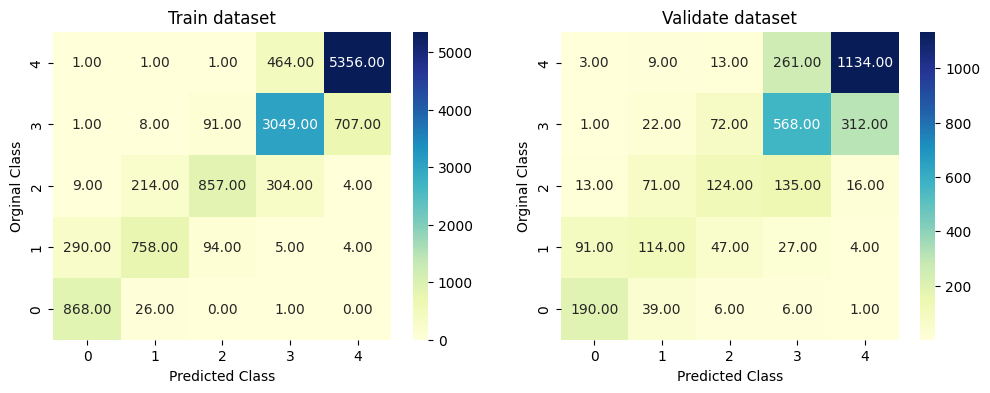

In [46]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.heatmap(
    np.flip(test_net_confusion_matrix(model_alternative_tokenizer, train_dataloader_alternative_tokenizer), 0),annot=True,cmap="YlGnBu",fmt=".2f",xticklabels=[0, 1, 2, 3, 4],yticklabels=[4, 3, 2, 1, 0],
)
plt.xlabel("Predicted Class")
plt.ylabel("Orginal Class")
plt.title("Train dataset")

plt.subplot(1,2,2)
sns.heatmap(
    np.flip(test_net_confusion_matrix(model_alternative_tokenizer, eval_dataloader_alternative_tokenizer), 0),annot=True,cmap="YlGnBu",fmt=".2f",xticklabels=[0, 1, 2, 3, 4],yticklabels=[4, 3, 2, 1, 0],
)
plt.xlabel("Predicted Class")
plt.ylabel("Orginal Class")
plt.title("Validate dataset")
plt.show()

Przy użyciu innego tokenizera otrzymaliśmy podobną skuteczność jak dla modelu pierwszego. Prawdopodobnie przy takim stosunkowo prostym zadaniu klasyfikacji nie ma to wpływu na nasze wyniki. Wykorzystane tokenizery są na tyle rozbudowane że w zupełności wystarczają.

## Generowanie predykcji

In [31]:
def generate_predictions(net, data_loader):
    net.eval()
    predictions = []
    for batch in data_loader:
        batch = {"attention_mask": batch['attention_mask'].to(device), "input_ids": batch['input_ids'].to(device)}#, "token_type_ids":batch['token_type_ids'].to(device)}

        with torch.no_grad():
            outputs = net(**batch)

        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1)
        predictions += preds
    return predictions

In [32]:
PREDS = generate_predictions(model3, test_dataloader)

In [33]:
df = pd.DataFrame(torch.tensor(PREDS).cpu())
df.size

4099

### Predykcje modelu 2

In [ ]:
df.to_csv("piatek_Jedrzejewski_Lopatecki-m2.csv", index=False, header=None)

array([[<Axes: title={'center': '0'}>]], dtype=object)

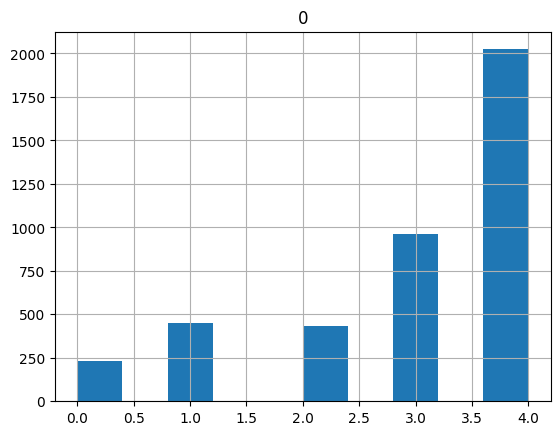

In [ ]:
df.hist()

### Predykcje modelu 3

In [34]:
df.to_csv("piatek_Jedrzejewski_Lopatecki-m3.csv", index=False, header=None)

array([[<Axes: title={'center': '0'}>]], dtype=object)

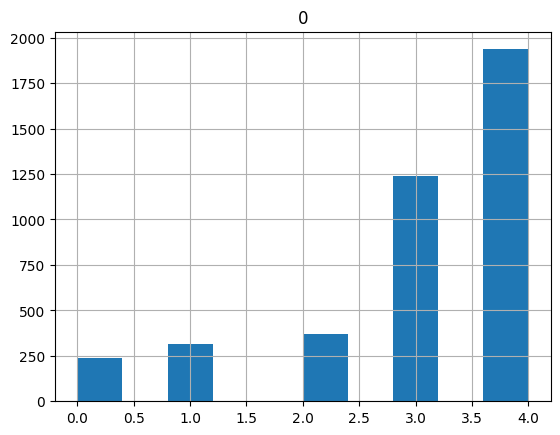

In [35]:
df.hist()

# Finalny model

Zdecydowanie najlepszą skuteczność miał model 3 wieć to właśnie predykcje trzeciego modelu zamieszczamy w naszych rozwiązaniach